# NextGenAICamp_Effective Deep Network Architecture Design (การออกแบบสถาปัตยกรรมโครงข่ายเชิงลึกอย่างมีประสิทธิภาพ)
จัดทำโดย จิรายุ เพชรแหน ภาควิชาวิศวกรรมคอมพิวเตอร์ คณะวิศวกรรมศาสตร์ สถาบันเทคโนโลยีพระจอมเกล้าเจ้าคุณทหารลาดกระบัง


-----
หัวข้อนี้จะกล่าวถึงการออกแบบการใช้งานบล็อคหรือเลเยอร์การคำนวณในโมเดลเชิงลึกแบบ Convolution ว่าควรออกแบบอย่างไรให้โมเดลเรียนรู้ของเราสามารถจดจำอย่างมีประสิทธิภาพ รวมถึงสามารถลดภาระการคำนวณเช่น ทรัพยากรการคำนวณ เวลา และอื่น ๆ ลงได้

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

# !pip install torchsummary
from torchsummary import summary

# การเลือกตัวเร่งประมวลผลสำหรับฝึกฝน (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title ฝึก cifar-10 dataset กับ CNNs

# กำหนด hyperparameters
num_epochs = 30
batch_size = 32
learning_rate = 0.001

# CIFAR10 dataset มี 10 คลาส
num_classes = 10

# เตรียมข้อมูลเทนเซอร์สำหรับการฝึก (แปลงข้อมูลเป็นเทนเซอร์ ฟลิบรูปแนวนอน สุ่มคล็อปภาพขนาด 32 และปรับให้เป็นมาตรฐานคือ Standard deviation=0.5 & mean=0.5 คล้ายกับการทำ standardscaler)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 54.5MB/s]


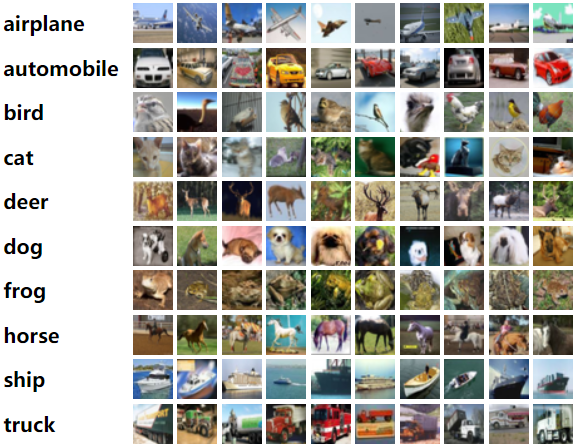

----
### SimpleCNN: การออกแบบโมเดลเชิงลึกโดยทั่วไปประกอบด้วย Conv-Pool

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = self.pool3(self.relu3(self.conv3(out)))
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# กำหนดโมเดล loss fn และตัวปรับปรุง
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
train_time = 0
for epoch in range(num_epochs):
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    for i, (images, labels) in enumerate(train_loader):
        t0 = time.time()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time += time.time() - t0
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    for images, labels in test_loader:
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()
    valid_accuracy = 100 * valid_correct / valid_total

    # if (i+1) % 100 == 0:
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print('Train accuracy of the model on the {} test images: {} %'.format(train_total, train_accuracy))
    print('Valid accuracy of the model on the {} test images: {} %'.format(valid_total, valid_accuracy))

    print('Accumulating training time: {:.2f} seconds'.format(train_time))
    print('----------------------------------------')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the model on the {} test images: {} %'.format(total, test_accuracy))

# เซฟโมเดลที่ฝึกเพื่อใช้ในอุปกรณ์อื่น ๆ
# torch.save(model.state_dict(), 'cifar10_cnn_model.pth')

Epoch [1/30], Step [1563/1563], Loss: 1.0667
Train accuracy of the model on the 50000 test images: 45.056 %
Valid accuracy of the model on the 10000 test images: 55.03 %
Accumulating training time: 4.39 seconds
----------------------------------------
Epoch [2/30], Step [1563/1563], Loss: 0.8567
Train accuracy of the model on the 50000 test images: 59.558 %
Valid accuracy of the model on the 10000 test images: 63.11 %
Accumulating training time: 9.02 seconds
----------------------------------------
Epoch [3/30], Step [1563/1563], Loss: 1.2697
Train accuracy of the model on the 50000 test images: 65.152 %
Valid accuracy of the model on the 10000 test images: 66.45 %
Accumulating training time: 13.52 seconds
----------------------------------------
Epoch [4/30], Step [1563/1563], Loss: 1.1414
Train accuracy of the model on the 50000 test images: 68.38 %
Valid accuracy of the model on the 10000 test images: 69.66 %
Accumulating training time: 17.97 seconds
--------------------------------

----
### VGG-16: ออกแบบพื้นที่รับภาพแบบ 3x3 กล่าวคือค่อย ๆ ลดขนาดฟีเจอร์ และลงลึกมากขึ้น
Designed by K. Simonyan and A. Zisserman, 2014

\
ถูกออกแบบมาให้มี 2 ขนาดด้วยกันคือ VGG-16 และ VGG-19 แต่เราจะมาดูการออกแบบ VGG-16 อย่างง่ายกัน

#### VGG-16
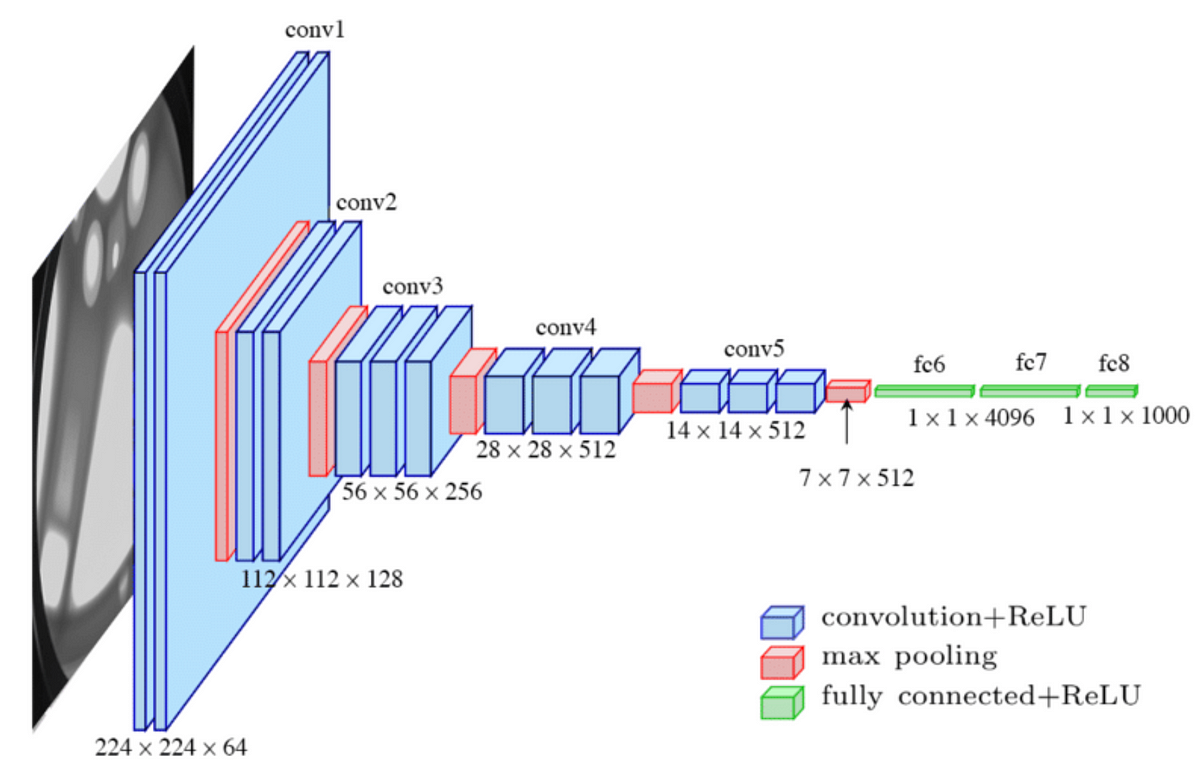

โดยใช้หลักการออกแบบปรับแก้ที่จากเพียงลงชั้นตื้นและใช้พื้นที่รับภาพใหญ่ไปและน้อยไป มาแก้เป็นพื้นที่รับภาพที่ละน้อย ๆ เช่น 3x3 และย้ำรายละเอียดในฟีเจอร์ด้วยพื้นที่รับภาพชาแนลที่เท่ากันหลาย ๆ รอบ จะช่วยให้การจดจำเพิ่มขึ้น

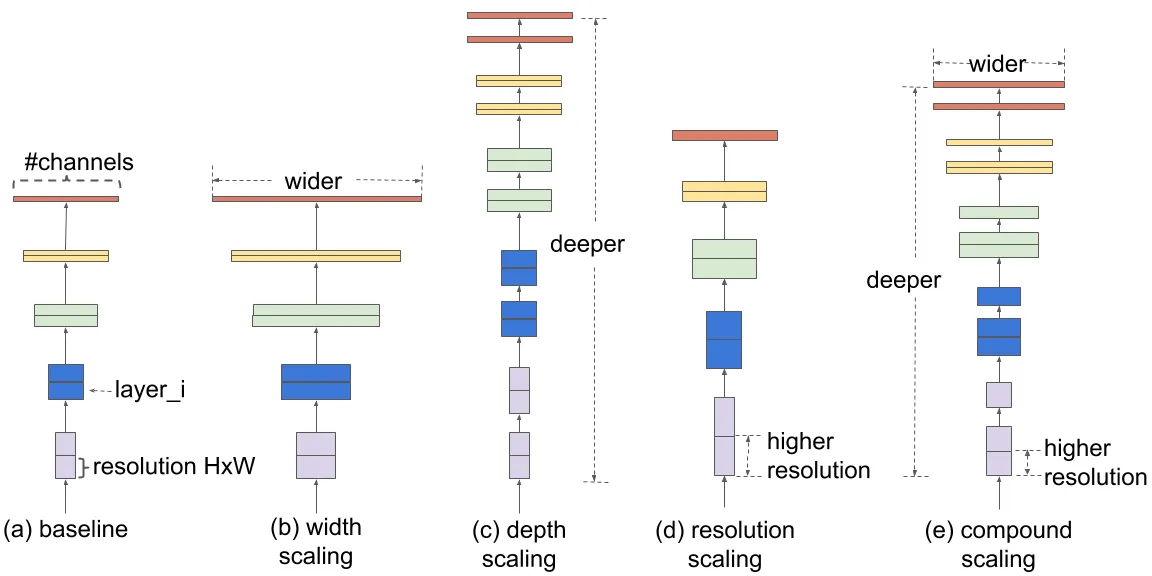

In [ ]:
# ฝึก cifar-10 dataset กับ CNNs แบบ VGG-16

# เตรียมข้อมูลเทนเซอร์สำหรับการฝึก (แปลงข้อมูลเป็นเทนเซอร์ ฟลิบรูปแนวนอน กำหนดขนาดภาพเป็น 224x224 แทนเนื่องจาก VGG-16 รับภาพขาเข้าที่ 224 และปรับให้เป็นมาตรฐานคือ Standard deviation=0.5 & mean=0.5 คล้ายกับการทำ standardscaler)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
])

# Load the CIFAR10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VGG-16
class VGG16(nn.Module):
    def __init__(self, n_C=10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, 1, 1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, 1, 1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_C)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))
        x = self.pool(F.relu(self.conv3_3(self.conv3_2(self.conv3_1(x)))))
        x = self.pool(F.relu(self.conv4_3(self.conv4_2(self.conv4_1(x)))))
        x = self.pool(F.relu(self.conv5_3(self.conv5_2(self.conv5_1(x)))))
        x = x.view(x.size(0), -1) # [32, 512, 7, 7] ---> [32, 512*7*7]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# กำหนดโมเดล loss fn และตัวปรับปรุง
learning_rate = 1e-4
model = VGG16(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
train_time = 0
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    for i, (images, labels) in enumerate(train_loader):
        t0 = time.time()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time += time.time() - t0
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    for images, labels in test_loader:
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()
    valid_accuracy = 100 * valid_correct / valid_total

    # if (i+1) % 100 == 0:
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print('Train accuracy of the model on the {} test images: {} %'.format(train_total, train_accuracy))
    print('Valid accuracy of the model on the {} test images: {} %'.format(valid_total, valid_accuracy))

    print('Accumulating training time: {:.2f} seconds'.format(train_time))
    print('----------------------------------------')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the model on the {} test images: {} %'.format(total, test_accuracy))

# เซฟโมเดลที่ฝึกเพื่อใช้ในอุปกรณ์อื่น ๆ
# torch.save(model.state_dict(), 'cifar10_cnn_model.pth')

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [1563/1563], Loss: 1.2164
Train accuracy of the model on the 50000 test images: 41.96 %
Valid accuracy of the model on the 10000 test images: 58.58 %
Accumulating training time: 11.34 seconds
----------------------------------------
Epoch [2/30], Step [1563/1563], Loss: 0.9223
Train accuracy of the model on the 50000 test images: 66.17 %
Valid accuracy of the model on the 10000 test images: 71.37 %
Accumulating training time: 22.14 seconds
----------------------------------------
Epoch [3/30], Step [1563/1563], Loss: 1.1218
Train accuracy of the model on the 50000 test images: 74.934 %
Valid accuracy of the model on the 10000 test images: 75.44 %
Accumulating training time: 32.88 seconds
----------------------------------------
Epoch [4/30], Step [1563/1563], Loss: 0.5964
Train accuracy of the model on the 50000 test images: 79.67 %
Valid accuracy of the model on the 10000 test images: 76.98 

----
### Inception Block: การลดปริมาณการใช้พารามิเตอร์ด้วยการประมวลผลแบบกิ่งขนาน - parallel branch
Designed by C. Szegedy et al., 2014.

\
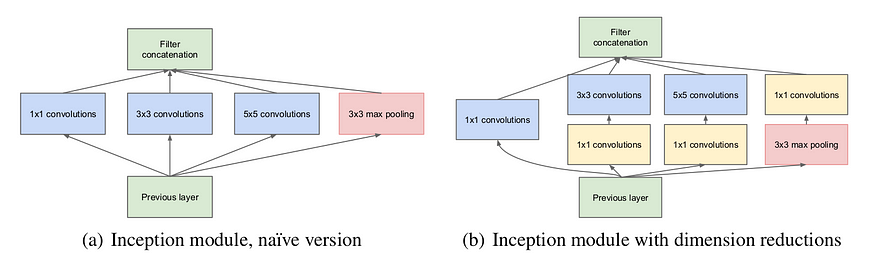




(a) การออกแบบแบบดั้งเดิม (naive version) คือการใช้ Covolutional block หลาย ๆ บล็อคมาคำนวณแบบขนาน จะพารามิเตอร์ในแต่ละกิ่ง (1x1, 3x3, และ 5x5) รวมกัน\
(b) การออกแบบเพื่อลดการใช้งานพารามิเตอร์ (dimension reductions) โดยใช้ 1x1 conv ก่อนเข้า processing conv (3x3 และ 5x5) เมื่อรวมพารามิเตอร์ที่ใช้กลับน้อยกว่า naive version

ตัวอย่างเปรียบเทียบการใช้งานก่อนและหลังใช้ 1x1 conv เพื่อลดการใช้ทรัพยากรคำนวณ (พารามิเตอร์เรียนรู้)

Direct 5x5 Conv:

*   จะเห็นว่าเมื่อลดจำนวนชาแนลโดยตรงผ่าน 5x5 (192 --> 32) ใช้พารามิเตอร์มากถึง 120 ล้านตัว

1x1 Conv before 5x5 Conv:

*   แต่ถ้าใช้ 1x1 ลดขนาดชาแนลมากกว่าเดิม (192 --> 16) ก่อนทำการใช้ 5x5 เพิ่มชาแนลทีหลัง (16 --> 32) จะเห็นพารามิเตอร์ที่ใช้รวมกันเป็น 2.4 + 10.0 = 12.4 ล้านตัว (ลดพารามิเตอร์ลงได้ประมาณ 8 เท่า)



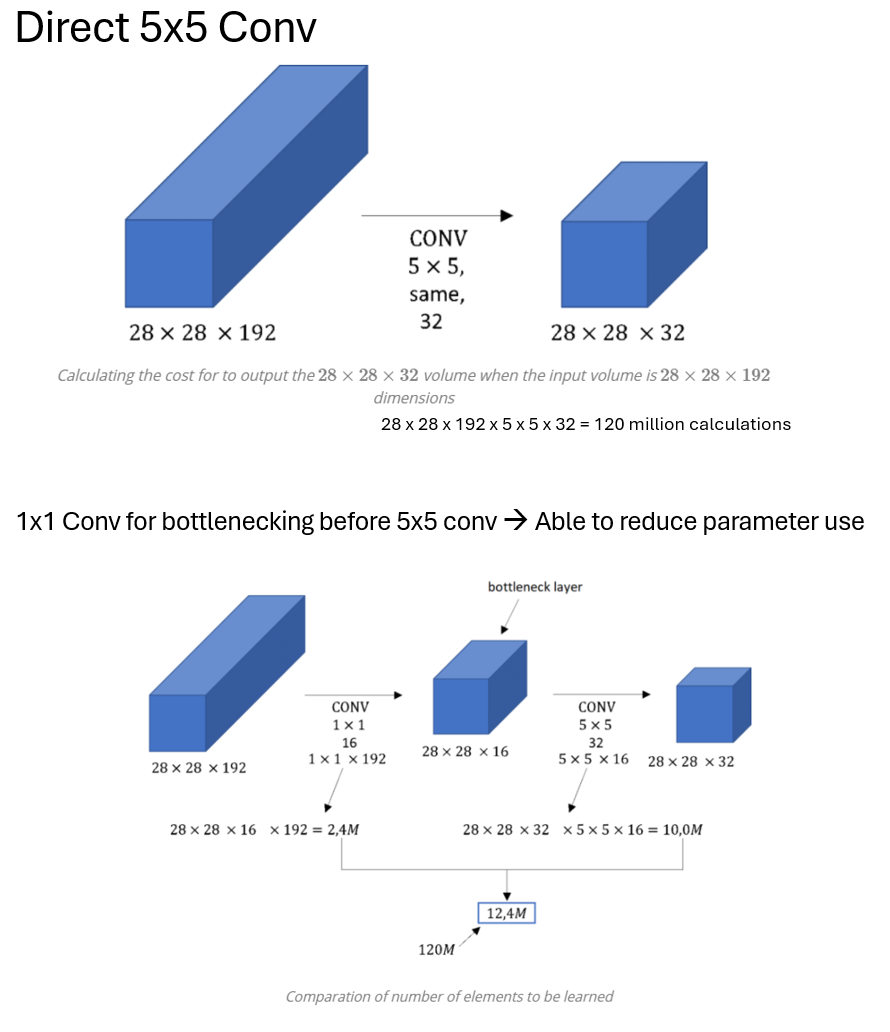

In [ ]:
# คำนวณพารามิเตอร์จากไลเบอรี่ torchsummary สำหรับ inception module (naive version (a) เทียบกับ dimension reductions (b))

class InceptionNaive(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionNaive, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class InceptionReduction(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionReduction, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

# ยกตัวอย่างจำนวน feature input size กับ feature output size ที่ขนาดเดียวกันเพื่อลองคำนวณพารามิเตอร์ที่ใช้จากทั้ง naive & reduction
in_channels = 64
ch1x1 = 16
ch3x3red = 16
ch3x3 = 32
ch5x5red = 8
ch5x5 = 16
pool_proj = 16

inception_naive = InceptionNaive(in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj).to(device)
inception_reduction = InceptionReduction(in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj).to(device)

print("Summary for Inception Naive:")
summary(inception_naive, input_size=(in_channels, 28, 28)) # สมมติที่ขนาดฟีเจอร์ = 28x28
print("\n" + "="*50 + "\n")
print("\nSummary for Inception Reduction:")
summary(inception_reduction, input_size=(in_channels, 28, 28))

Summary for Inception Naive:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,040
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]          18,464
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]          25,616
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 64, 28, 28]               0
Total params: 45,120
Trainable params: 45,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.15
Params size (MB): 0.17
Estimated Total Size (MB): 1.51
----------------------------------------------------------------



Summary for Inception Reduction:
-------------------------------------------

นำมาสู่การใช้ Inception block สร้างต่อกันกลายเป็น GoogLeNet ซึ่งถูกออกแบบให้ทุก ๆ inception block ที่ปรับใช้สามารถสร้าง feature map output ได้ทุก block

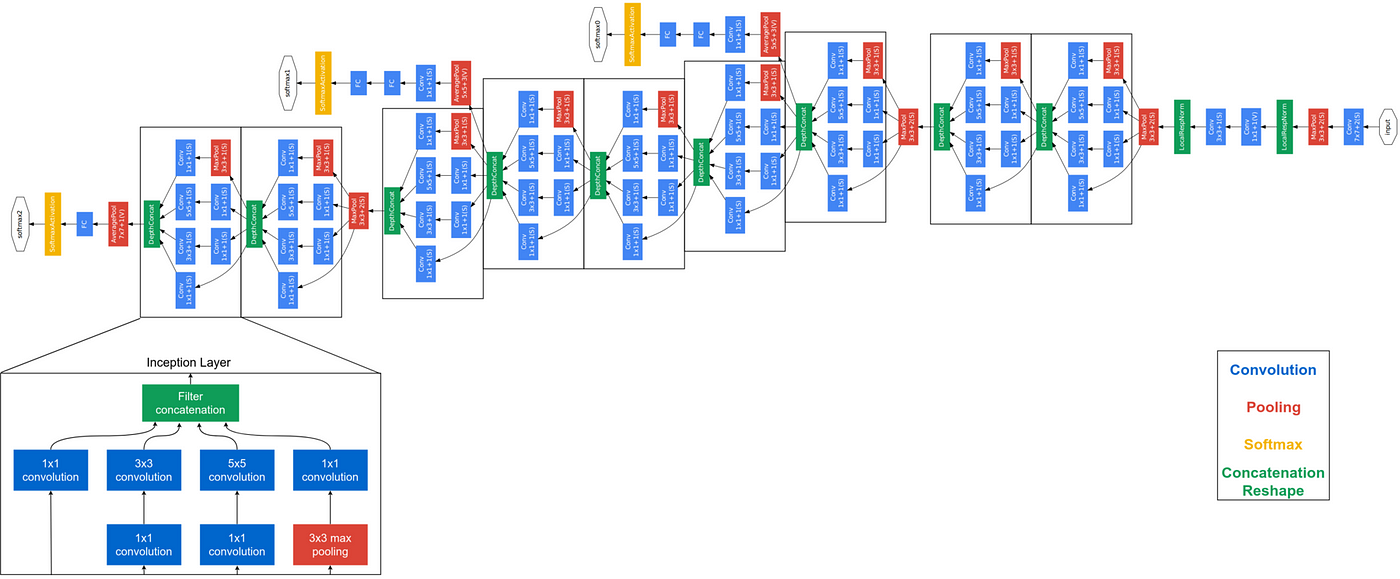

In [ ]:
# ฝึก cifar-10 dataset กับ CNNs แบบ GoogLeNet

# เตรียมข้อมูลเทนเซอร์สำหรับการฝึก (แปลงข้อมูลเป็นเทนเซอร์ ฟลิบรูปแนวนอน กำหนดขนาดภาพเป็น 224x224 แทนเนื่องจาก VGG-16 รับภาพขาเข้าที่ 224 และปรับให้เป็นมาตรฐานคือ Standard deviation=0.5 & mean=0.5 คล้ายกับการทำ standardscaler)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
])

# Load the CIFAR10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# กำหนด Inception block ใช้ใน GoogLeNet
class Inception(nn.Module):
  def __init__(self, in_channels, ch1x1, ch3x3reduce, ch3x3, ch5x5reduce, ch5x5, pool_proj):
    super(Inception, self).__init__()
    self.branch1 = nn.Sequential(
        nn.Conv2d(in_channels, ch1x1, kernel_size=1),
        nn.ReLU(inplace=True)
    )
    self.branch2 = nn.Sequential(
        nn.Conv2d(in_channels, ch3x3reduce, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch3x3reduce, ch3x3, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    self.branch3 = nn.Sequential(
        nn.Conv2d(in_channels, ch5x5reduce, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch5x5reduce, ch5x5, kernel_size=5, padding=2),
        nn.ReLU(inplace=True)
    )
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_channels, pool_proj, kernel_size=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class GoogLeNet(nn.Module):
  def __init__(self, num_classes=1000):
    super(GoogLeNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(0.2)

    # สำหรับ inception 4e for final output
    # self.fc = nn.Linear(832, num_classes)
    # สำหรับ inception 5b for final output
    self.fc = nn.Linear(1024, num_classes)

    # for m in self.modules():
    #     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #         torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)
    #     elif isinstance(m, nn.BatchNorm2d):
    #         nn.init.constant_(m.weight, 1)
    #         nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

# กำหนดโมเดล loss fn และตัวปรับปรุง
learning_rate = 1e-4 # ปรับ learning rate สำหรับ GoogLeNet
model = GoogLeNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # ลด learning rate ทุก 5 epochs

# Training loop
total_step = len(train_loader)
train_time = 0
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    for i, (images, labels) in enumerate(train_loader):
        t0 = time.time()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time += time.time() - t0
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total
    # scheduler.step()

    model.eval()
    for images, labels in test_loader:
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()
    valid_accuracy = 100 * valid_correct / valid_total

    # if (i+1) % 100 == 0:
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print('Train accuracy of the model on the {} test images: {} %'.format(train_total, train_accuracy))
    print('Valid accuracy of the model on the {} test images: {} %'.format(valid_total, valid_accuracy))

    print('Accumulating training time: {:.2f} seconds'.format(train_time))
    print('----------------------------------------')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the model on the {} test images: {} %'.format(total, test_accuracy))

# เซฟโมเดลที่ฝึกเพื่อใช้ในอุปกรณ์อื่น ๆ
# torch.save(model.state_dict(), 'cifar10_cnn_model.pth')

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [1563/1563], Loss: 1.3336
Train accuracy of the model on the 50000 test images: 28.96 %
Valid accuracy of the model on the 10000 test images: 36.74 %
Accumulating training time: 27.18 seconds
----------------------------------------
Epoch [2/30], Step [1563/1563], Loss: 1.1355
Train accuracy of the model on the 50000 test images: 41.948 %
Valid accuracy of the model on the 10000 test images: 46.7 %
Accumulating training time: 53.23 seconds
----------------------------------------
Epoch [3/30], Step [1563/1563], Loss: 1.2316
Train accuracy of the model on the 50000 test images: 49.774 %
Valid accuracy of the model on the 10000 test images: 54.52 %
Accumulating training time: 78.99 seconds
----------------------------------------
Epoch [4/30], Step [1563/1563], Loss: 0.8423
Train accuracy of the model on the 50000 test images: 56.786 %
Valid accuracy of the model on the 10000 test images: 58.14

เทียบการใช้พารามิเตอร์เชิงคำนวณในโมเดลเทียบกันระหว่าง SimpleNet, VGG16, และ GoogLeNet

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = self.pool3(self.relu3(self.conv3(out)))
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


class VGG16(nn.Module):
    def __init__(self, n_C=10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, 1, 1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, 1, 1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_C)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))
        x = self.pool(F.relu(self.conv3_3(self.conv3_2(self.conv3_1(x)))))
        x = self.pool(F.relu(self.conv4_3(self.conv4_2(self.conv4_1(x)))))
        x = self.pool(F.relu(self.conv5_3(self.conv5_2(self.conv5_1(x)))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

print("Summary for SimpleCNN:")
summary(SimpleCNN(10).to(device), input_size=(3, 32, 32))
print("Summary for VGG16:")
summary(VGG16(10).to(device), input_size=(3, 224, 224))
print("\n" + "="*50 + "\n")
print("\nSummary for GoogLeNet:")
summary(GoogLeNet(10).to(device), input_size=(3, 224, 224))

Summary for SimpleCNN:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                   [-1, 10]          20,490
Total params: 113,738
Trainable params: 113,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.98
Params size

----
### Residual Block: บล็อคจดจำหลังจากหลงลืมความรู้ระหว่างทาง
Designed by K. He et al., 2015.

\
ในระหว่างการคำนวณลงลึกไปเรื่อย ๆ ยิ่งออกแบบให้โมเดลมีความลึกมากเท่าไหร่ส่งผลให้ความรู้ที่คำนวณมาได้ในชั้นตื้น ๆ จะเริ่มจางหายไปเรื่อย ๆ ด้วยเหตุนี้การออกแบบก้าน identity; x เปรียบเสมือนการรักษาน้ำหนักเดิมจากบล็อคก่อนหน้าคล้ายกับการรักษาความรู้คงเหลือ (Residual representations) นำมารวมกับน้ำหนักที่ผ่านการประมวลผลชั้นเลเยอร์น้ำหนัก weight layer (กล่าวคือชั้น Conv ที่เราใช้คำนวณ) ทำให้การจดจำสามารถรักษาความรู้เดิมที่มีประโยชน์ใช้ต่อได้

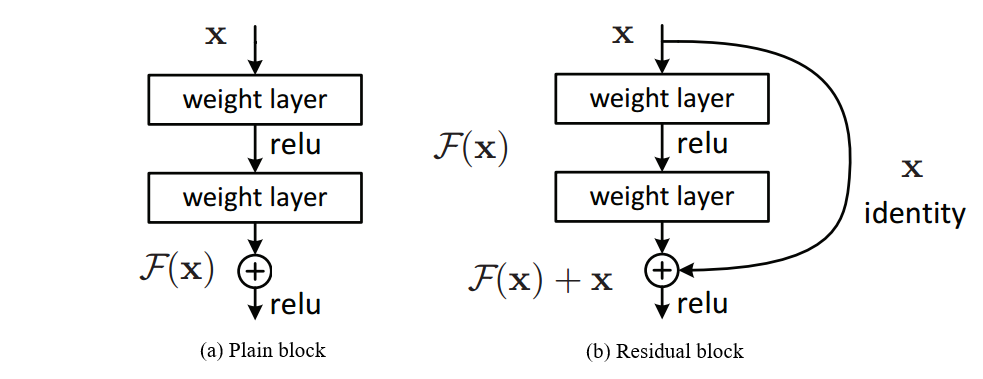

In [ ]:
# @title 1. สร้างบล็อครักษาน้ำหนักคงเหลือ (residual block) คล้ายกับการทำบล็อคคำนวณก้านขนานของ inception block
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

โดยปกติแล้ว Residual Network ออกแบบมาให้มี 5 ขนาดด้วยกันคือ

*   Basic block: ResNet-18 และ ResNet-34
*   Bottleneck block: ResNet-50, ResNet-151, และ ResNet-152

เรามาดูตัวอย่างการออกแบบ Residual block อย่างง่ายให้ออกมาเป็น Residual Network 18 blocks ต่อกัน

*   ใช้การเข้ารหัสฟีเจอร์ Residual block ด้วยจำนวนชาแนลเดิมทุก ๆ 2 blocks
*   ใช้การเข้ารหัสฟีเจอร์ Residual block ทั้งหมด 8 ชุดด้วยกัน (64(2 blocks) --> 128(2 blocks) --> 256(2 blocks) --> 512(2 blocks))


\
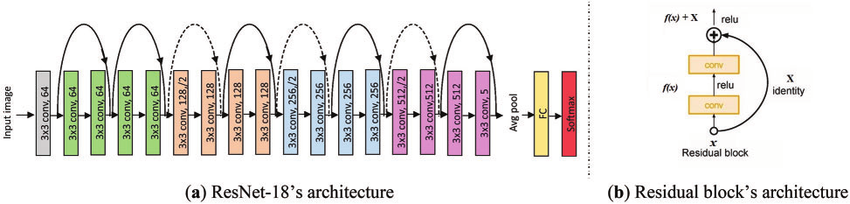

In [ ]:
# @title 2.1 การกำหนดบล็อคใหญ่และเลเยอร์ทั้งหมดสำหรับ Residual Network; ResNet แบบเป็นโครงข่ายธรรมดา plain network

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1_block1 = BasicBlock(64, 64, stride=1)
        self.layer1_block2 = BasicBlock(64, 64, stride=1)

        self.layer2_block1 = BasicBlock(64, 128, stride=2)
        self.layer2_block2 = BasicBlock(128, 128, stride=1)

        self.layer3_block1 = BasicBlock(128, 256, stride=2)
        self.layer3_block2 = BasicBlock(256, 256, stride=1)

        self.layer4_block1 = BasicBlock(256, 512, stride=2)
        self.layer4_block2 = BasicBlock(512, 512, stride=1)

        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def forward(self, x):
        out = self.maxpool(F.relu(self.bn1(self.conv1(x))))

        out = self.layer1_block1(out) #64
        out = self.layer1_block2(out)

        out = self.layer2_block1(out) #128
        out = self.layer2_block2(out)

        out = self.layer3_block1(out) #256
        out = self.layer3_block2(out)

        out = self.layer4_block1(out) #512
        out = self.layer4_block2(out)

        out = nn.AdaptiveAvgPool2d((1, 1))(out) # [32, 512, 7, 7] --> [32, 512, 1, 1]
        out = out.view(out.size(0), -1) # [32, 512]

        out = self.linear(out)
        return out

print("\nSummary for ResNet-18:")
summary(ResNet18(10).to(device), input_size=(3, 224, 224))


Summary for ResNet-18:
torch.Size([2, 64, 56, 56])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
        BasicBlock-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
       BasicBlock-13           [-1, 64, 56, 56]    

In [ ]:
# @title 2.2 การกำหนดบล็อคใหญ่และเลเยอร์ทั้งหมดสำหรับ Residual Network; ResNet แบบรวบรัดโดยกำหนด self._make_layer
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # For matching dimensions if needed
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):  # default: ImageNet
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution and maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
# @title 3. กำหนดฟังก์ชันใช้งาน ResNet-18 (ตัวอย่าง 18 blocks อย่างง่าย)
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


print("\nSummary for ResNet-18:")
summary(resnet18(10).to(device), input_size=(3, 224, 224))


Summary for ResNet-18:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             Re

ตัวอย่างการรักษาน้ำหนักด้วย Residual block เมื่อเทียบกับ Plain network จะเห็นว่ามีการรักษาน้ำหนักจากต้นทางไปจนถึงปลายทางการคำนวณอยู่ตลอดเวลา

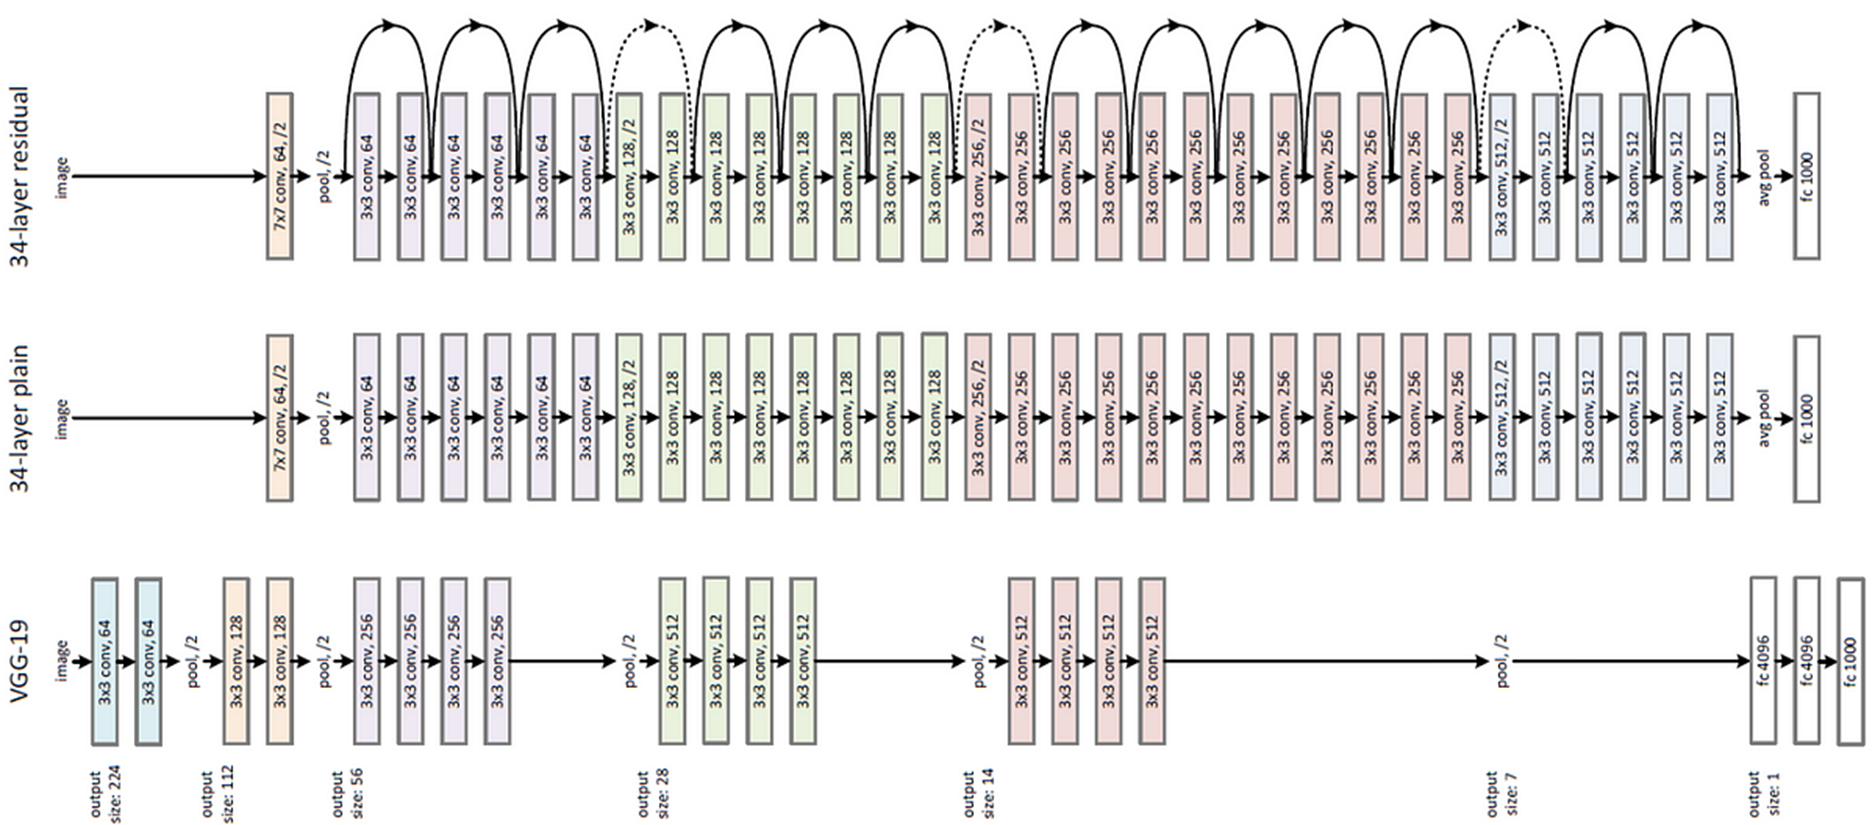

5 Residual Network ที่ถูกออกแบบมาให้ใช้งาน

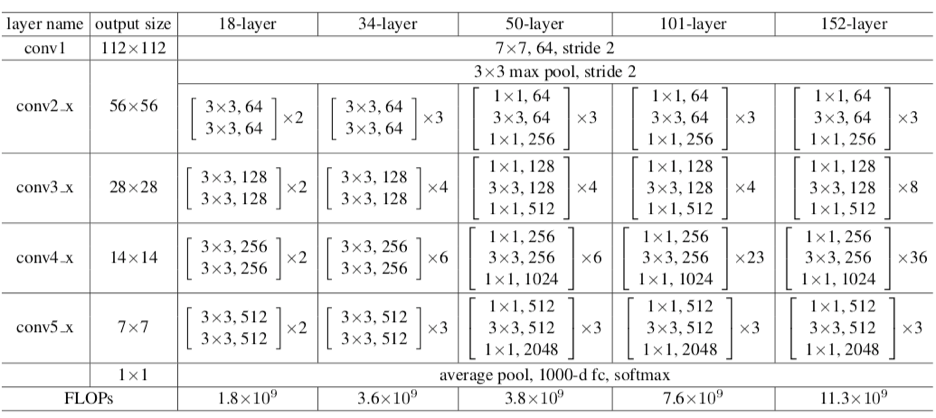

ตัวอย่าง Residual Network แบบ Bottleneck (ResNet-50, -101, -152)


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

# กำหนดจำนวนบล็อคในตาราง
def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)



print("\nSummary for ResNet-50:")
summary(resnet50(10).to(device), input_size=(3, 224, 224))


Summary for ResNet-50:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       Bottleneck-13          [-1, 256, 56, 56]               0
           Conv

In [ ]:
# ฝึก cifar-10 dataset กับ CNNs แบบ Residual Network 18 blocks

# เตรียมข้อมูลเทนเซอร์สำหรับการฝึก (แปลงข้อมูลเป็นเทนเซอร์ ฟลิบรูปแนวนอน กำหนดขนาดภาพเป็น 224x224 แทนเนื่องจาก VGG-16 รับภาพขาเข้าที่ 224 และปรับให้เป็นมาตรฐานคือ Standard deviation=0.5 & mean=0.5 คล้ายกับการทำ standardscaler)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
])

# Load the CIFAR10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# กำหนดโมเดล loss fn และตัวปรับปรุง
learning_rate = 1e-4
model = resnet18(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
train_time = 0
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    for i, (images, labels) in enumerate(train_loader):
        t0 = time.time()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time += time.time() - t0
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    for images, labels in test_loader:
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()
    valid_accuracy = 100 * valid_correct / valid_total

    # if (i+1) % 100 == 0:
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print('Train accuracy of the model on the {} test images: {} %'.format(train_total, train_accuracy))
    print('Valid accuracy of the model on the {} test images: {} %'.format(valid_total, valid_accuracy))

    print('Accumulating training time: {:.2f} seconds'.format(train_time))
    print('----------------------------------------')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the model on the {} test images: {} %'.format(total, test_accuracy))

# เซฟโมเดลที่ฝึกเพื่อใช้ในอุปกรณ์อื่น ๆ
# torch.save(model.state_dict(), 'cifar10_cnn_model.pth')

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [1563/1563], Loss: 0.8592
Train accuracy of the model on the 50000 test images: 56.892 %
Valid accuracy of the model on the 10000 test images: 65.99 %
Accumulating training time: 15.90 seconds
----------------------------------------
Epoch [2/30], Step [1563/1563], Loss: 0.6075
Train accuracy of the model on the 50000 test images: 74.64 %
Valid accuracy of the model on the 10000 test images: 74.57 %
Accumulating training time: 31.22 seconds
----------------------------------------
Epoch [3/30], Step [1563/1563], Loss: 0.7286
Train accuracy of the model on the 50000 test images: 79.952 %
Valid accuracy of the model on the 10000 test images: 80.54 %
Accumulating training time: 47.04 seconds
----------------------------------------
Epoch [4/30], Step [1563/1563], Loss: 0.2963
Train accuracy of the model on the 50000 test images: 83.728 %
Valid accuracy of the model on the 10000 test images: 79.9

### ผลทดสอบกับชุดข้อมูลทดสอบ CIFAR-10 พิจารณาที่ 30 epoches

| โมเดล (30 epoches) |  Train Loss | Train Accuracy (%) | Valid Accuracy (%) | Test Accuracy (%) | Params (Unit) | Accumulating time (Second)|
|-|-|-|-|-|-|-|
|SimpleCNN|0.3403|81.31|78.08|77.78|113,738|135.07|
|VGG16|0.0032|98.65|78.43|78.89|134,301,514|324.42|
|GoogLeNet|0.1019|95.59|79.37|79.24|5,983,802|777.90|
|ResNet-18|0.0930|98.65|85.33|85.45|11,173,962|471.44|

### สรุปและอภิปราย
การปรับจำนวน ชั้นเลเยอร์ และ/หรือความสามารถของบล็อคพิเศษเพื่อเพิ่มการจดจำและความเข้าใจในตัวอย่างจากชุดข้อมูลมีผลต่อประสิทธิภาพโมเดลโดยตรง แต่ก็ต้องแลกมาด้วยการประมวลผลที่นานขึ้นและใช้เวลาสกัดข้อมูลที่นานขึ้น แต่อย่างไรก็ตามเหรียญย่อมมี 2 ด้าน การออกแบบที่ใช้งานอะไรก็ตามมากเกินไปก็อาจจะไม่ช่วยให้การประมวลผลเป็นได้ด้วยดีเพียงอย่างเดียว ดังนั้นการออกแบบจำเป็นต้องพิจารณาหลาย ๆ ด้านควบคู่กัน

\
อนึ่ง ตัวอย่างข้างต้นเป็นเพียงการออกแบบพื้นฐานสำหรับโมเดลเรียนรู้ที่มีประโยชน์จากการแข่งขันในยุคที่โมเดลเชิงลึกกำลังเกิดขึ้น แต่ยังมีวิธีอื่นอีกมากมายหลังจากนั้นซึ่งถูกออกแบบมาให้เหมาะกับการใช้งานเฉพาะด้าน เช่น การลดจำนวนพารามิเตอร์ในการใช้งานจาก MobileNet หรือ EfficientNet หรือโมเดลที่เน้นใช้งานด้านประสิทธิภาพ ResNet-50, ResNeXt, SENet, ViT เป็นต้น สามารถดูเพิ่มได้ที่ https://github.com/ddlee-cn/awesome_cnn/tree/master/models

----
# แบบฝึกหัด

1. จงออกแบบโมเดลเรียนรู้ใหม่ที่ใช้ประมวลผลชุดข้อมูล CIFAR-10 โดยให้ออกแบบจำนวน kernel, stride, padding, residual block, inception block, learning rate, และอื่น ๆ อย่างเหมาะสมและอิสระที่สามารถรองรับต่อการประมวลผลจนเรียนรู้เสร็จสิ้นและทำนายผลได้ **เกิน 77.78%** ที่วัดผลจากข้อมูลทดสอบจาก *SimpleCNN model* ซึ่งเป็นโมเดลจากตัวอย่างแรก
```python
          ภาพขาเข้าขนาด 3x224x224 ที่ทำการ transform แล้ว
                              |
                              |
                              V
บล็อคหรือเลเยอร์ที่ออกแบบประกอบด้วย inception และ/หรือ residual blocks
                      **อย่างน้อยหนึ่งบล็อค**
                              |
                              |
                              V
                          Flattening
                              |
                              |
                              V
        Fully-connected output (10 classes สำหรับ CIFAR-10)
```